Logistic Regression and Multi-Layered Perceptron
=========================================

We consider the example problem from lecture 1. We are given two datasets: one containing linearly separable clusters and one containing two concentric rings (not linearly separable).

Your task is to implement and study the behavior of the classification methods discussed in the lecture: linear regression as classification, logistic regression, MLP.

## Imports

In [273]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

FIG_SIZE=(12,8)

## Two datasets

In [274]:
def two_clusters(N, variance=0.1):
    N1 = N // 2
    N2 = N - N1
    X1 = np.random.randn(N1, 2) * variance + 0.25
    X2 = np.random.randn(N2, 2) * variance + 0.75
    X = np.concatenate([X1, X2], axis=0)
    T = np.concatenate([np.zeros((N1)), np.ones((N2))], axis=0)
    p = np.random.permutation(N)
    return X[p], T[p]

def two_rings(N, separation=0.1, noise=0.2):
    N1 = N // 2
    N2 = N - N1
    angles = np.random.rand(N, 1) * 2 * np.pi
    radius = np.random.rand(N, 1) + np.random.randn(N, 1) * noise
    radius *= .5 - separation / 2
    radius[N2:] += .5 + separation / 2
    X = np.concatenate([radius * np.sin(angles), radius * np.cos(angles)], axis=1)
    T = np.concatenate([np.zeros((N1)), np.ones((N2))], axis=0)
    p = np.random.permutation(N)
    return X[p], T[p]

In [275]:
def visualize_dataset(X, T, Y=None):
    m = ["x", "o"]  # Indicates true class
    col = ["red", "blue"]  # Indicates prediction
    fig = plt.figure(figsize=FIG_SIZE); plt.axis('equal')
    if Y is not None:
        idx_tp = np.logical_and(T >= .5, Y >= .5) # True positives
        idx_fp = np.logical_and(T < .5, Y >= .5) # False positives
        idx_fn = np.logical_and(T >= .5, Y < .5) # False negatives
        idx_tn = np.logical_and(T < .5, Y < .5) # True negatives
        
        plt.scatter(X[idx_tp,0], X[idx_tp,1], marker=m[0], c="red", label="TP")
        plt.scatter(X[idx_fp,0], X[idx_fp,1], marker=m[1], c="red", label="FP")
        plt.scatter(X[idx_fn,0], X[idx_fn,1], marker=m[0], c="blue", label="FN")
        plt.scatter(X[idx_tn,0], X[idx_tn,1], marker=m[1], c="blue", label="TN")

    else:
        idx_pos, idx_neg = (T > .5), (T < .5)
        plt.scatter(X[idx_pos,0], X[idx_pos,1], marker=m[0], color="blue", label="Pos")
        plt.scatter(X[idx_neg,0], X[idx_neg,1], marker=m[1], color="blue", label="Neg")
    
    plt.xlabel("x"); plt.ylabel("y")
    plt.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
    return fig.axes[0]

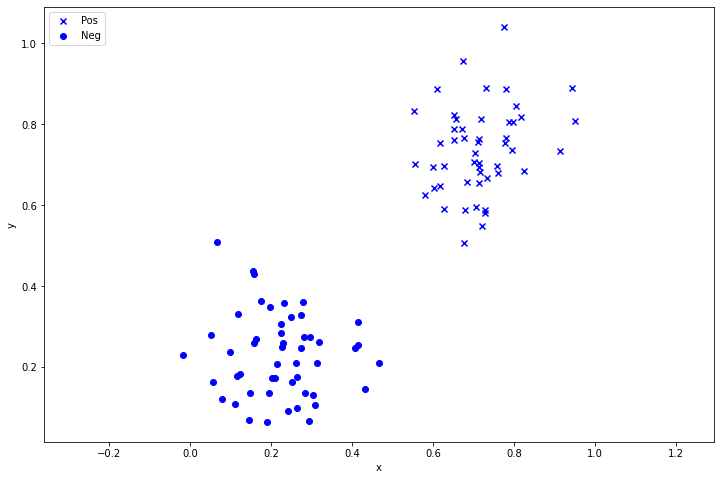

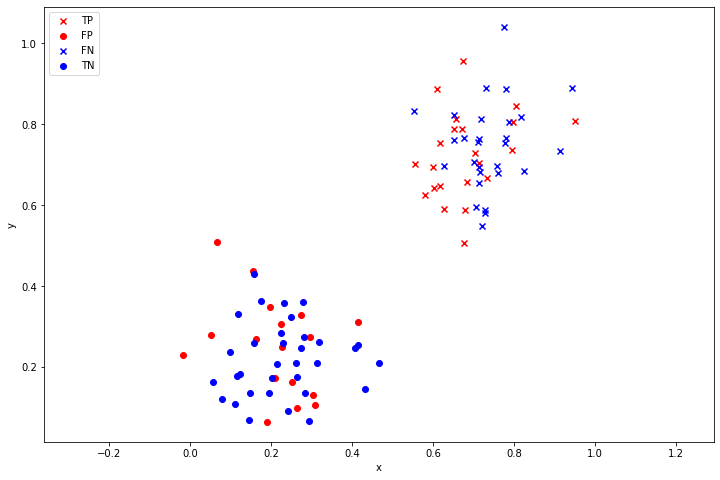

In [276]:
X, T = two_clusters(100, variance=0.1)
visualize_dataset(X, T, Y=None);
visualize_dataset(X, T, Y=np.random.uniform(size=T.size));

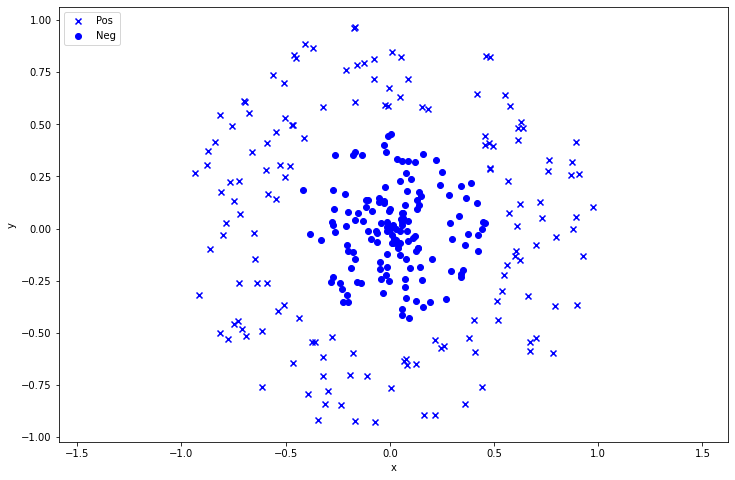

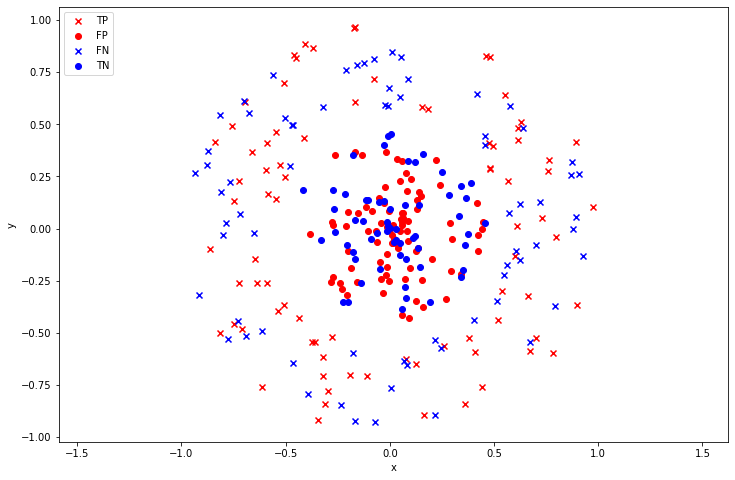

In [277]:
X, T = two_rings(300, noise=0.01)
visualize_dataset(X, T, Y=None);
visualize_dataset(X, T, Y=np.random.uniform(size=T.size));

Task 1: Using linear regression for classification?
========================================

We'll use the following convention: ${\bf w}^{\text{T}}{\bf x} + b = 1$ for positive examples and ${\bf w}^{\text{T}}{\bf x} +b = 0$ for negative examples.

Actually: $\hat{x} = [x_0, x_1, 1]$ and $y = {\bf w}^{\text{T}}\hat{{\bf x}}$

In [278]:
def train_linear(X, T):
    N = X.shape[0]
    X_hat = np.concatenate([X, np.ones((N, 1))], axis=1)

    # TODO <1.1>: W = ...
    # return W
    return np.linalg.solve(np.dot(X_hat.T, X_hat), np.dot(X_hat.T, T))

In [279]:
def predict_linear(X, W):
    N = X.shape[0]
    X_hat = np.concatenate([X, np.ones((N, 1))], axis=1)
    Y = np.dot(X_hat, W)
    return Y

(3,)


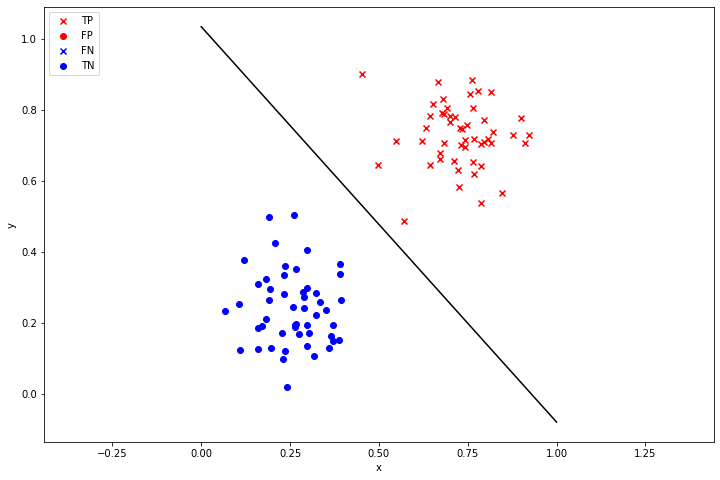

In [280]:
X, T = two_clusters(100, variance=0.1)
W = train_linear(X, T)
print(W.shape)
Y = predict_linear(X, W)
ax = visualize_dataset(X, T, Y);

__x = np.linspace(0, 1, 100)
__y = (.5 - __x * W[0] - W[2]) / W[1]

plt.plot(__x, __y, c="black", axes=ax)
plt.show()

### How about adding some other examples that should pose no problems?

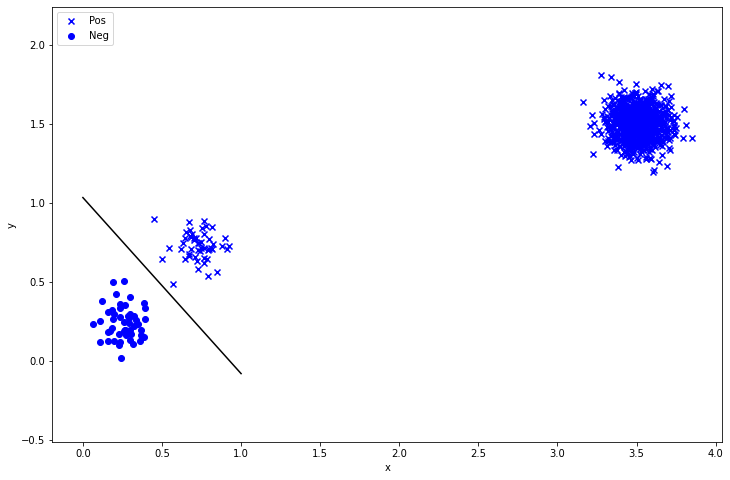

In [281]:
extra_N = 800
extra_X = np.random.randn(extra_N, 2) * 0.1
extra_X[:,1] += 1.5
extra_X[:,0] += 3.5
extra_T = np.ones(extra_N)
X_full = np.concatenate([X, extra_X], axis=0)
T_full = np.concatenate([T, extra_T], axis=0)

ax = visualize_dataset(X_full, T_full, Y=None);
__x = np.linspace(0, 1, 100)
__y = (.5 - __x * W[0] - W[2]) / W[1]

plt.plot(__x, __y, c="black", axes=ax)
plt.show()

### Let's train the model on full data

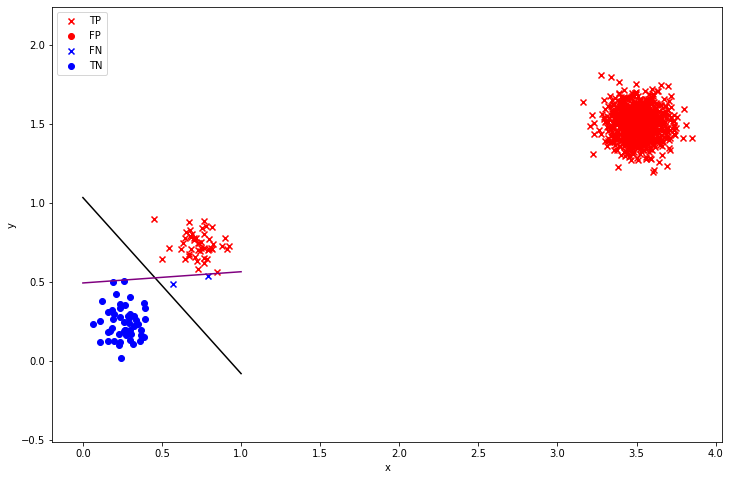

In [282]:
W_full = train_linear(X_full, T_full)
Y = predict_linear(X_full, W_full)
ax = visualize_dataset(X_full, T_full, Y);

__x = np.linspace(0, 1, 100)
__y = (.5 - __x * W[0] - W[2]) / W[1]
plt.plot(__x, __y, c="black", axes=ax)

__y = (.5 - __x * W_full[0] - W_full[2]) / W_full[1]
plt.plot(__x, __y, c="purple", axes=ax)


plt.show()

Task 2 - Logistic Regression
=======================

### The logistic function

$$\sigma(x) = \frac{1}{1 + e^{-x}}$$


In [283]:
def logistic(x):
    # TODO <2.1> Implement the logistic function
    return 1 / (1 + np.exp(-x))

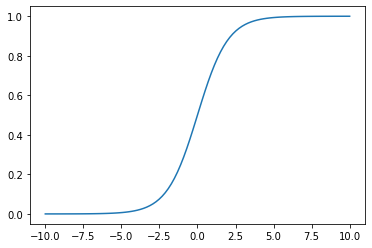

In [284]:
x = np.linspace(-10, 10, 100)
plt.plot(x, logistic(x))

### Learning logistic regression models for classification

Let us define the loss function: **cross-entropy**, which has the same mathematical formulation as the **negative log-likelihood** (NLL).

We also define a metric to evaluate the effectiveness of our model, in this case, **accuracy** (the percentage of correctly classified inputs).

In [285]:
def nll(Y, T):
    idx0 = (T > 0.5)
    idx1 = (T < 0.5)
    return -np.sum(np.log(Y[idx0])) - np.sum(np.log(1.0 - Y[idx1]))

def accuracy(Y, T):
    N = Y.shape[0]
    return np.sum(((T < 0.5) & (Y < 0.5)) | ((T > 0.5) & (Y > 0.5))) / N

print("NLL:", nll(np.random.uniform(size=(100)), T))
print("Accuracy: ", accuracy(np.random.uniform(size=(100)), T))

NLL: 98.5665880093147
Accuracy:  0.44


In [286]:
def split_dataset(X, T, train=.8):
    N = X.shape[0]
    N_train = int(round(N * train))
    N_test = N - N_train

    X_train, X_test = X[:N_train,:], X[N_train:,:]
    T_train, T_test = T[:N_train], T[N_train:]
    return X_train, T_train, X_test, T_test


## Logistic regression

In [287]:
def train_logistic(X, T, lr=.01, epochs_no=10):
     # TODO <2.2> : Make 100 steps of SGD to train the values of the W matrix
     N = X.shape[0]
     X_norm = np.concatenate([X, np.ones((N, 1))], axis=1)
     W = np.array([0.0, 0.0, 0.0])
     gradient = W
     for _ in range(epochs_no):
       pi = np.dot(W, X_norm.T)
       diff = logistic(pi) - T
       gradient = np.dot(X_norm.T, diff)
       W -= lr * gradient
     return W

def predict_logistic(X, W):
    # TODO <2.3> : Compute the model's predictions
    N = X.shape[0]
    X_hat = np.concatenate([X, np.ones((N, 1))], axis=1)
    Y = np.dot(W, X_hat.T)
    return Y.T

### Let's test it!
We evaluate the trained model on the _two clusters_ dataset, plotting the separation line.

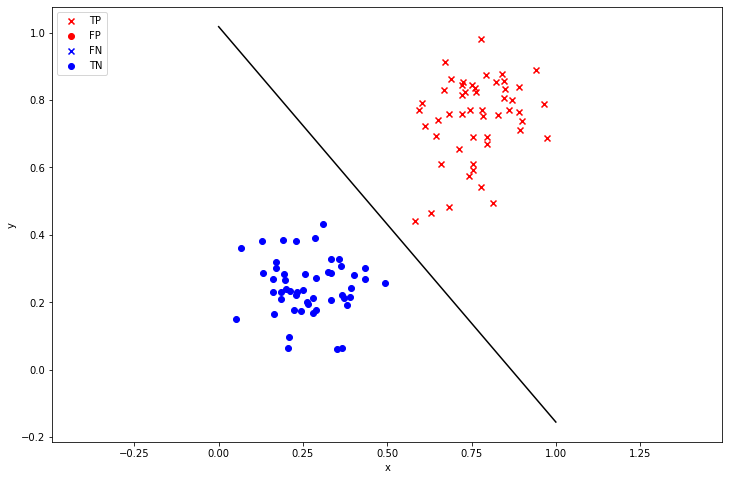

In [288]:
X, T = two_clusters(100, variance=0.1)
W = train_logistic(X, T, lr=.1, epochs_no=1000)
Y = predict_logistic(X, W)
ax = visualize_dataset(X, T, Y);

__x = np.linspace(0, 1, 100)
__y = (-__x * W[0] - W[2]) / W[1]

plt.plot(__x, __y, c="black", axes=ax)
plt.show()

How is the separation line altered for the case of logistic regression, if we add in extra points for one of the clusters?

Do we have the same issue as was the case for linear regression as classification?

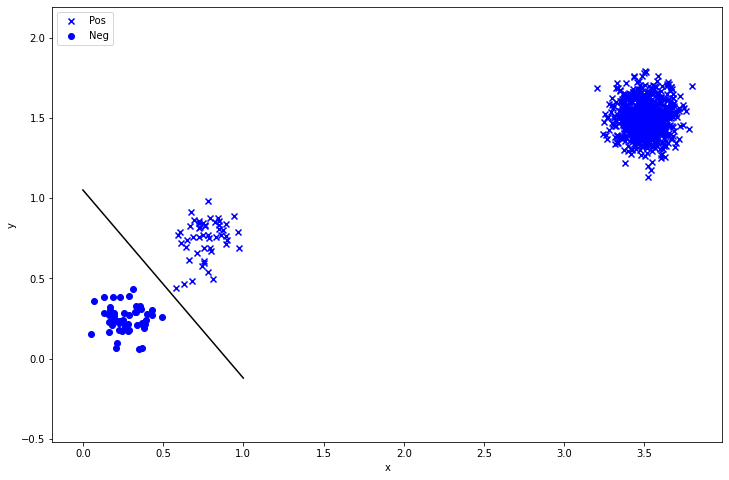

In [289]:
extra_N = 800
extra_X = np.random.randn(extra_N, 2) * 0.1
extra_X[:,1] += 1.5
extra_X[:,0] += 3.5
extra_T = np.ones(extra_N)
X_full = np.concatenate([X, extra_X], axis=0)
T_full = np.concatenate([T, extra_T], axis=0)

ax = visualize_dataset(X_full, T_full, Y=None);
__x = np.linspace(0, 1, 100)
__y = (.5 - __x * W[0] - W[2]) / W[1]

plt.plot(__x, __y, c="black", axes=ax)
plt.show()

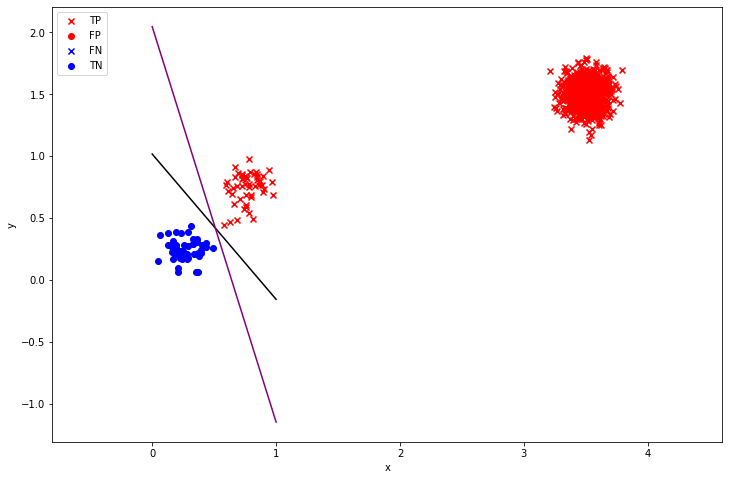

In [290]:
W_full = train_logistic(X_full, T_full, lr=.1, epochs_no=10000)
Y = predict_logistic(X_full, W_full)
ax = visualize_dataset(X_full, T_full, Y);

__x = np.linspace(0, 1, 100)
__y = (- __x * W[0] - W[2]) / W[1]
plt.plot(__x, __y, c="black", axes=ax)

__y = (- __x * W_full[0] - W_full[2]) / W_full[1]
plt.plot(__x, __y, c="purple", axes=ax)


plt.show()

### Plotting train and test curves for the logistic regression model
We modify the train procedure to keep a record of train and test values for our objective function (NLL) and our evaluation metric (accuracy).
This helps us draw the train and test curves for the learned logistic regression model.

In [291]:
def train_logistic_full(X, T, lr=.01, epochs_no=100):
    (N, D) = X.shape
    X1 = np.concatenate([np.ones((N, 1)), X], axis=1)
    W = np.random.randn((D+1))

    X_train, T_train, X_test, T_test = split_dataset(X1, T)

    train_acc, test_acc = [], []
    train_nll, test_nll = [], []
    W_trace = [W.copy()]

    for epoch in range(epochs_no):
        Y_train = logistic(np.dot(X_train, W))
        # TODO <2.4> Update parameters: use same update rule as for task 2.2
        # W -= ...
        diff = Y_train - T_train
        gradient = np.dot(X_train.T, diff)
        W -= lr * gradient

        # Just for plotting
        Y_test = 1. / (1. + np.exp(-np.dot(X_test, W)))
        train_acc.append(accuracy(Y_train, T_train))
        test_acc.append(accuracy(Y_test, T_test))
        train_nll.append(nll(Y_train, T_train))
        test_nll.append(nll(Y_test, T_test))
        W_trace.append(W.copy())
        
    return W, train_acc, test_acc, train_nll, test_nll, W_trace

In [292]:
def plot_evolution(train_acc, test_acc, train_nll, test_nll):
    epochs_no = len(train_acc)
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=FIG_SIZE);
    ax1.plot(range(epochs_no), train_acc, sns.xkcd_rgb["green"], label="Train Accuracy")
    ax1.plot(range(epochs_no), test_acc, sns.xkcd_rgb["red"], label="Test Accuracy")
    ax1.set_ylabel("Accuracy")
    ax1.legend(loc='lower right', ncol=1)

    ax2.plot(range(epochs_no), train_nll, sns.xkcd_rgb["green"], label="Train NLL")
    ax2.plot(range(epochs_no), test_nll, sns.xkcd_rgb["red"], label="Test NLL")
    ax2.set_xlabel("iteration")
    ax2.set_ylabel("NLL")
    ax2.legend(loc='upper right', ncol=1);
    return (ax1, ax2)

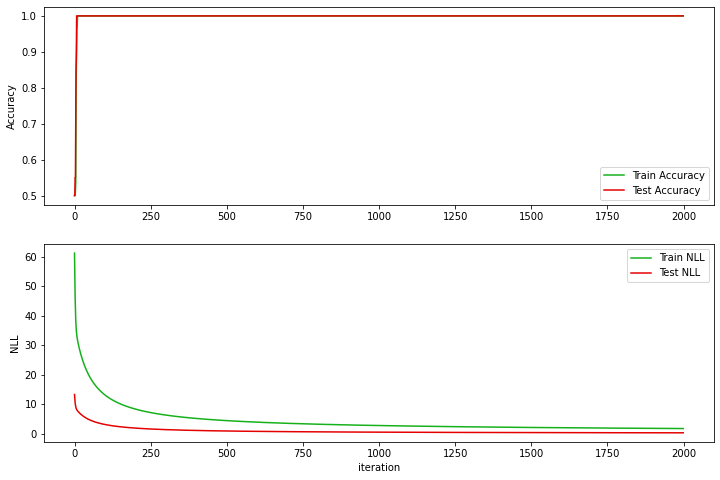

In [293]:
EPOCHS_NO = 2000
results = train_logistic_full(X, T, lr=.01, epochs_no=EPOCHS_NO)

W, train_acc, test_acc, train_nll, test_nll, W_trace = results
plot_evolution(train_acc, test_acc, train_nll, test_nll);


del EPOCHS_NO, results, W, train_acc, test_acc, train_nll, test_nll, W_trace

### What about the second dataset?
What is the performance of the logistic regression method on the second dataset (the _concentric rings_ )? 

What is the explanation for the observed performance? 

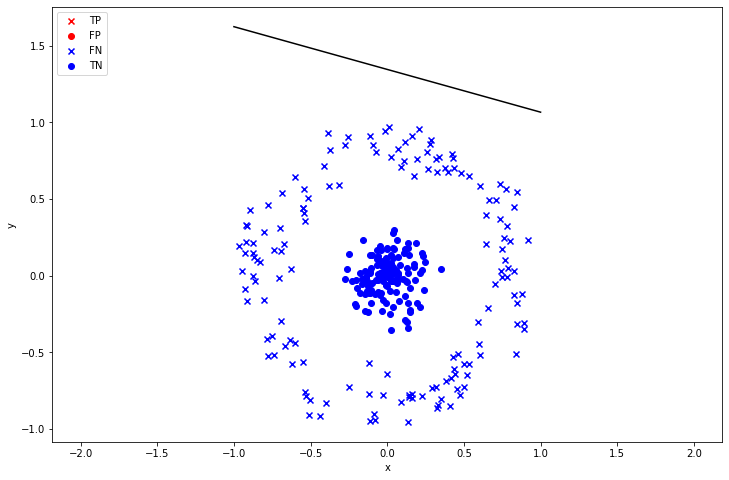

In [294]:
X, T = two_rings(300, separation=.4)
W = train_logistic(X, T, lr=.1, epochs_no=1000)
Y = predict_logistic(X, W)
ax = visualize_dataset(X, T, Y);

__x = np.linspace(-1, 1, 100)
__y = (-__x * W[0] - W[2]) / W[1]

plt.plot(__x, __y, c="black", axes=ax)
plt.show()

Task 3: Multi-Layered Perceptron
===========================

### Imports

In [295]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

For the _concentric rings_ dataset, we need a model that is able to handle non-linearly separable data. 

The **Multi-Layered Perceptron**  is a _fully-connected_ network model, wherein each node in a layer learns to compute a separation hyperplane for the input it receives.
The number of nodes in a layer determines the dimensionality of the input space in which the layer nodes have to compute the separation hyperplane. 

By choosing the dimensionality of the intermediary ( _hidden_ ) layers effectively, the MLP can learn how to classify non-linearly separable data, by projecting it into a space where linear decision boundaries are possible.

### Creating a MLP using torch

Your first task is to create the model for the MLP presented in the lecture. 

The model contains:
  - An input layer of size 2
  - A hidden layer of size 3
  - An output layer of size 2: one unit that should fire for the positive class (y=1) and one that should fire for the negative class (y=0)

In [296]:
def create_MLP_model():
    # TODO <3.1> Create the MLP model using torch primitives
    
    # linear1 = ...  // create the input linear layer of size 2x3: hint nn.Linear
    linear1 = nn.Linear(2, 3)
    # linear2 = ... // create the hidden linear layer of size 3x2: hint nn.Linear
    linear2 = nn.Linear(3, 2)
    # Put the two linear models in sequence, by passing through a non-linearity. We will use Tanh as the activation function. 
    # Why are we not using Sigmoid? Test out what happens if you do.
    # Our final model is the following: linear1 --> Tanh() --> linear2
    # model = ... // hint: nn.Sequential()
    # return model
    # false negatives seem to appear while using a sigmoid function
    #model = nn.Sequential(linear1, nn.Sigmoid(), linear2)
    model = nn.Sequential(linear1, nn.Tanh(), linear2)
    return model

**Prepare the dataset**

In [297]:
X, T = two_rings(1000, separation=.2, noise=.1)

X = torch.from_numpy(X).clone().float()
T = torch.from_numpy(T).clone().long()

X_train, T_train, X_test, T_test = split_dataset(X, T, train=.15)

### Training the MLP

In [298]:
EPOCHS_NO = 6000

def train_MLP(X_train, T_train, X_test, T_test, lr=1e-2, momentum=.9, epochs_no=EPOCHS_NO):
    # Create the model
    model = create_MLP_model()
    
    # Set the optimizer: SGD with learning rate = lr and momentum=momentum
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    losses = []
    
    # keep track of accuracy and NLL to plot train/test curves
    train_acc, test_acc, train_nll, test_nll = [], [], [], []

    for _ in range(epochs_no):
        # initialize gradients for current batch - in our case we train using the full-batch method (average gradients over the whole dataset)
        optimizer.zero_grad()
        
        # obtain the output / prediction of the model
        Y_train = model(X_train)
        
        # compute the loss: we use cross entropy between our prediction and the target
        loss = F.cross_entropy(Y_train, T_train)
        
        # Do backprop to update the model parameters
        loss.backward()
        optimizer.step()
        
        # put model in evaluation mode - no gradient update - to compute loss for test set
        model.eval()
        Y_test = model(X_test)
        eval_loss = F.cross_entropy(Y_test, T_test)
        
        # put model back in train mode for next epoch
        model.train()
        
        # compute training accuracy
        _, ind = Y_train.max(dim=1)
        train_acc.append((ind == T_train).sum().item() / Y_train.size(0))
        
        # compute test accuracy
        _, ind = Y_test.max(dim=1)
        test_acc.append((ind == T_test).sum().item() / Y_test.size(0))
        
        # compute nll values for train and test
        train_nll.append(loss.item())
        test_nll.append(eval_loss.item())
        
    return model, train_nll, train_acc, test_nll, test_acc

In [299]:
model, train_nll, train_acc, test_nll, test_acc = train_MLP(X_train, T_train, X_test, T_test)

**Plot the training evolution result**

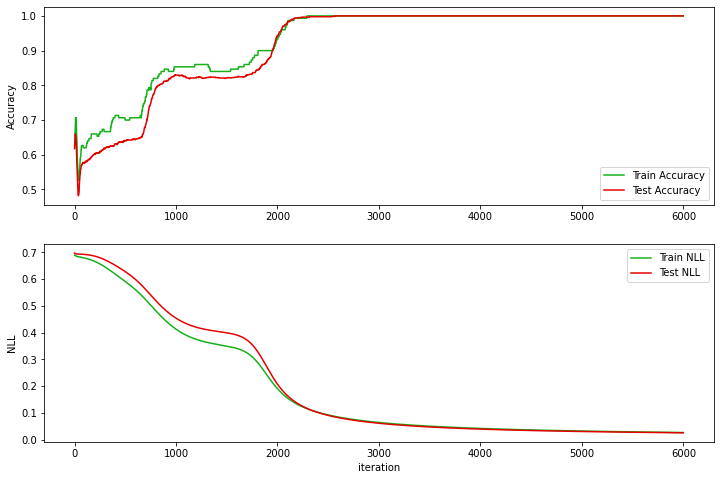

In [300]:
plot_evolution(train_acc, test_acc, train_nll, test_nll)
plt.show()

### Visualize trained model performance

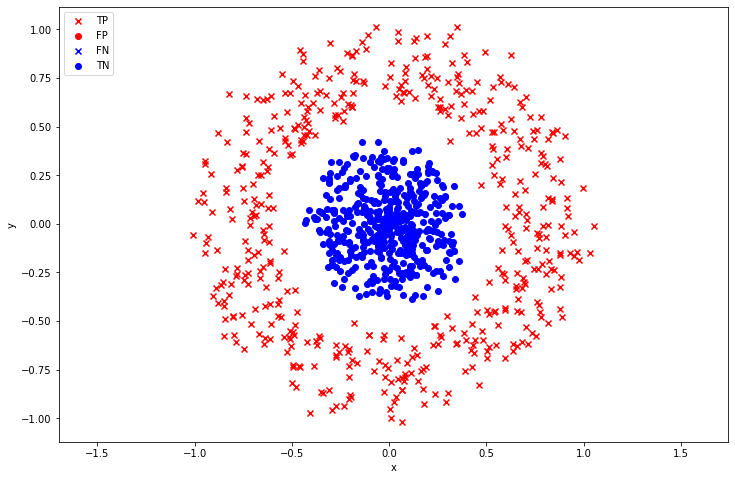

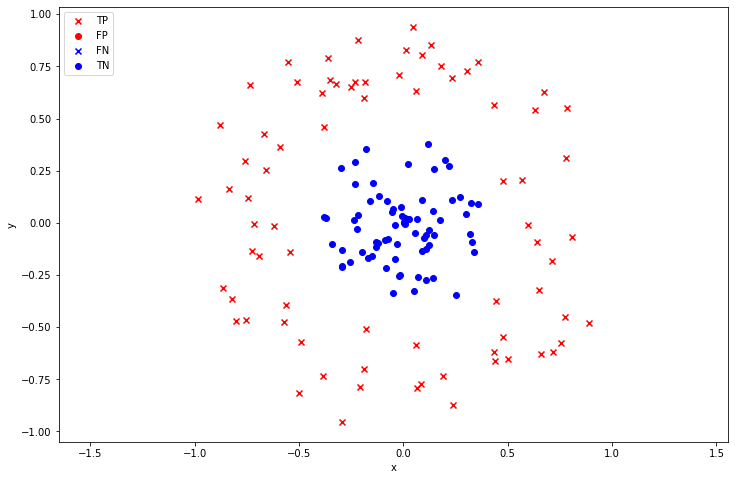

In [301]:
_, Y = model(X).max(dim=1)
_, Y_train = model(X_train).max(dim=1)
visualize_dataset(X.numpy(), T.numpy(), Y=Y.numpy());
visualize_dataset(X_train.numpy(), T_train.numpy(), Y=Y_train.numpy());

### Visualize Decision Boundaries

Let us have a look at the first linear layer, examining the `weight` and `bias` attributes.

In [302]:
linear1_layer = list(model.children())[0]

In [303]:
linear1_layer.weight, linear1_layer.bias

(Parameter containing:
 tensor([[ 4.2917,  1.7387],
         [-0.8930, -4.4761],
         [ 4.1032, -3.1218]], requires_grad=True), Parameter containing:
 tensor([-1.5315, -1.4353,  1.8841], requires_grad=True))

Notice that the `weight` attribute returns a 3x2 tensor containing the weights that relate each of the 2 input nodes with each of the 3 hidden layer nodes.

The `bias` attribute returns a 1x3 tensor containing a bias term for each of the 3 hidden layer nodes. 

Our decision boundaries are given by the equation $w_0 \times x + w_1 \times y + b = 0$ (since we are using the Tanh function).

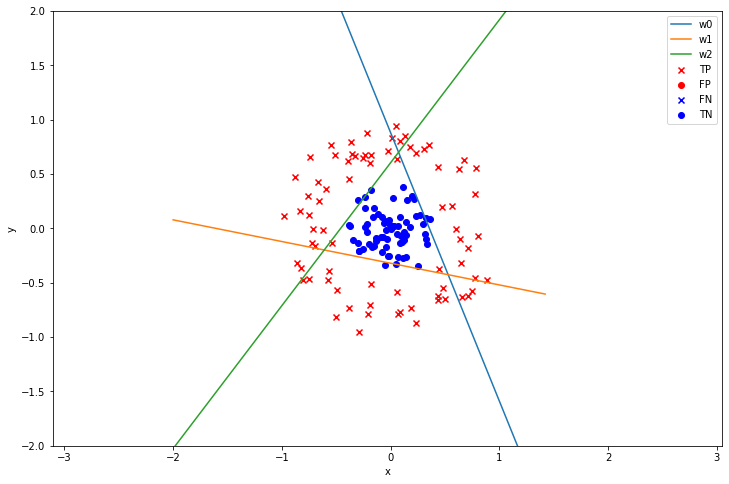

In [304]:
ax = visualize_dataset(X_train.numpy(), T_train.numpy(), Y=Y_train.numpy());
plt.ylim(-2, 2)
for i in range(linear1_layer.weight.size(0)):
    # TODO <3.2> extract the w and b terms for each of the hidden layer neorns (in our case three)
    # w = ... // extract the weight vector for node `i` from linear1_layer
    w = linear1_layer.weight[i]
    # b = ... // extract the bias term for node `i` from linear1_layer
    b = linear1_layer.bias[i]
    
    __x = np.linspace(-2, 2 - np.random.rand(), 100)  # we generate 100 `x` values uniformely distanced in a space between [-2, 2)
    # __y = .... // compute the expected y point for a given `x`, given the decision boundary equation
    __y = np.zeros(__x.shape)
    for j in range(100):
      __y[j] = (-b - w[0] * __x[j]) / w[1]
    plt.plot(__x, __y, axes=ax, label=f"w{i}")
    
plt.legend()
plt.show()

Let us now analyze what the second layer does. It operates on a 3 dimensional input space (the 3 hidden nodes) and it has to align the weights in such a way that the output of the positive node is always > .5 for the positive class and the output of the negative node is always < .5 for the negative class.

We will want to alter the model in place to see the effect of changing a weight in the final layer has. So first, let us copy make a copy of our trained model.

In [305]:
model_state = model.state_dict()

In [306]:
new_model = create_MLP_model()

In [307]:
new_model.load_state_dict(model_state)

<All keys matched successfully>

In [308]:
    new_linear2 = list(new_model.children())[2]

In [309]:
new_linear2.weight

Parameter containing:
tensor([[-2.8343, -3.3486,  3.6344],
        [ 3.6288,  3.1015, -2.9519]], requires_grad=True)

In [310]:
new_linear2.bias

Parameter containing:
tensor([-5.0990,  5.3053], requires_grad=True)

Let us change the sign of the `new_linear2.weight[:,2]` and see how the classification is affected.

In [311]:
new_linear2.weight[:, 2].data *= -1

Visualize classification results for altered model

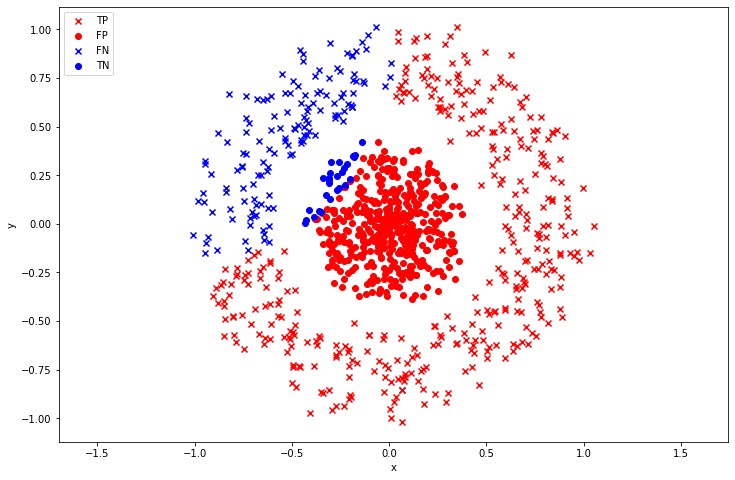

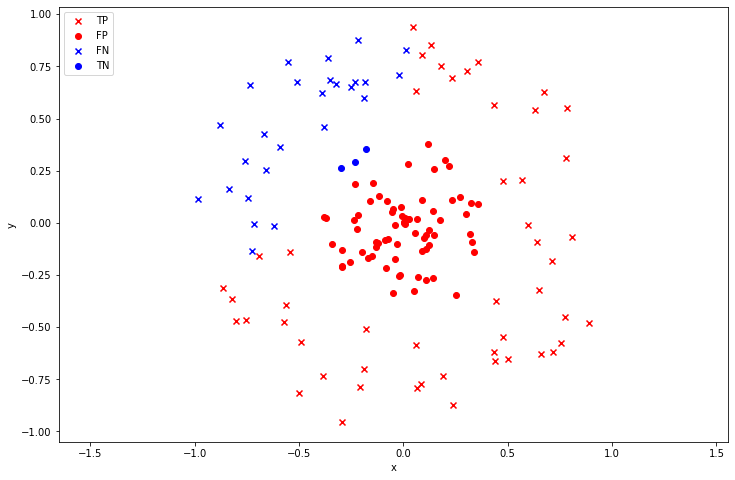

In [312]:
_, Y = new_model(X).max(dim=1)
_, Y_train = new_model(X_train).max(dim=1)
visualize_dataset(X.numpy(), T.numpy(), Y=Y.numpy());
visualize_dataset(X_train.numpy(), T_train.numpy(), Y=Y_train.numpy());

In [315]:
# The reason why the tanh is better than the sigmoid in this case is because the gradient of the tanh function is
# stronger in comparision to sigmoid's, so it might be more accurate for our data points.
# Also sigmoid's output is in range (0, 1), while the tanh's output range is in (-1, 1), which might also contribute
# to the accuracy of the result while using our data set.